# HSG-12M

HSG-12M Spatial Multigraph Dataset.

This repository contains the code in the companion paper "HSG-12M: A Large-Scale Spatial Multigraph Dataset":
- the code for generation of HSG-12M
- the code to derive the six dataset variants, and generic custom subsets
- the code for preliminary featurization and processing to PyTorch Geometric Dataset (both in memory and on disk)
- the code for benchmarking on GNN baseline models

The 1401 data files are publicly available at [Dataverse](https://doi.org/10.7910/DVN/PYDSSQ).

The dataset is generated by [`poly2graph`](https://github.com/sarinstein-yan/poly2graph).

## Raw Data Files

The download of raw data files is by `easyDataverse`, which sometimes encounters timeout connecting to Dataverse. Retry or connect to better network if you encounter timeout when initializing the dataset.

In [ ]:
from easyDataverse import Dataverse

server_url = "https://dataverse.harvard.edu"
dataset_pid = "doi:10.7910/DVN/PYDSSQ"

dv = Dataverse(server_url)
hsg = dv.load_dataset(
    pid=dataset_pid, 
    # local directory to save files
    filedir='.',
    # which classes to download
    filenames=[f'raw/class_{i}.npz' for i in range(1401)],
    # Set to True to download the files, requires at least 257GB of free space
    download_files=False,
)

# metadata
print(hsg.citation)

Take the **9-th** class as an example, if the `raw/class_9.npz` file is downloaded, one can load the `nx.MultiGraph` objects, class label `y`, the parameter values `a_vals`, `b_vals`, and the class-specific metadata as follows:

In [2]:
import hsg

nx_graphs, y, a_vals, b_vals, class_metas = hsg.load_class(class_idx=9, raw_dir='./dev/raw')

print("class label:", y)
print("a_vals:", a_vals)
print("b_vals:", b_vals)
print("polynomial latex:", class_metas['latex'])
print("polynomial parameter symbols:", class_metas['parameter_symbols'])
print("polynomial generators:", class_metas['generator_symbols'])
print("number of bands:", class_metas['number_of_bands'])
print("max left hopping:", class_metas['max_left_hopping'])
print("max right hopping:", class_metas['max_right_hopping'])
import sympy as sp
poly = sp.sympify(class_metas['sympy_repr'])
poly

class label: 9
a_vals: [-10.-5.j -10.-2.j -10.-1.j ...  10.+1.j  10.+2.j  10.+5.j]
b_vals: [-10.-5.j -10.-5.j -10.-5.j ...  10.+5.j  10.+5.j  10.+5.j]
polynomial latex: - E + \frac{a}{z} + b z + z^{2} + \frac{1}{z^{2}}
polynomial parameter symbols: ['a' 'b']
polynomial generators: ['z' '1/z' 'E']
number of bands: 1
max left hopping: 2
max right hopping: 2


Poly(z**2 + b*z + (1/z)**2 + a*(1/z) - E, z, 1/z, E, domain='ZZ[a,b]')

[(0, {'pos': array([-7.85831195,  5.63079328]), 'dos': np.float32(0.25101075), 'potential': np.float32(-1.7545433)}), (3, {'pos': array([6.69559824, 3.57594968]), 'dos': np.float32(0.23724917), 'potential': np.float32(-1.6002026)}), (6, {'pos': array([1.56957655, 0.94456724]), 'dos': np.float32(0.085914895), 'potential': np.float32(-1.2916195)}), (7, {'pos': array([ 1.20739188, -3.80079098]), 'dos': np.float32(0.23262492), 'potential': np.float32(-1.4785695)})]
[(0, 6, {'weight': np.float64(11.322210064669378), 'pts': array([[-7.81765857,  5.61601023],
       [-7.80287552,  5.61601023],
       [-7.78809248,  5.61601023],
       ...,
       [ 1.54001045,  0.95935029],
       [ 1.5547935 ,  0.95935029],
       [ 1.56957655,  0.94456724]], shape=(636, 2)), 'avg_dos': np.float32(0.07713379), 'avg_potential': np.float32(-1.5248148)}), (3, 6, {'weight': np.float64(6.169199202476567), 'pts': array([[6.65494486, 3.56116664],
       [6.64016181, 3.56116664],
       [6.62537877, 3.56116664],
   

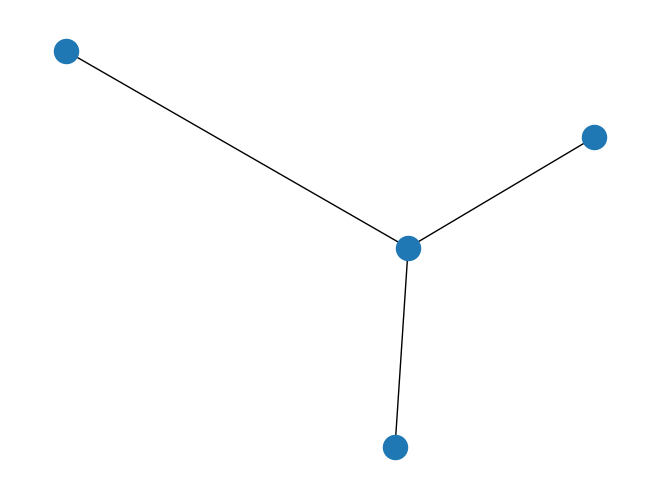

In [3]:
import networkx as nx

graph = nx_graphs[1234]

print(graph.nodes(data=True))
print(graph.edges(data=True))

pos = nx.get_node_attributes(graph, 'pos')
nx.draw(graph, pos)

## PyG Datasets

The download of raw data files is by `easyDataverse`, which sometimes encounters timeout connecting to Dataverse. Retry or connect to better network if you encounter timeout when initializing the dataset.

The NetworkX MultiGraph dataset is processed to PyTorch Geometric Dataset via the scheme discussed in the companion paper. 

Feel free to overwrite the `process` method in `HSGOnDisk` or `HSGInMemory` to customize the featurization and processing.

In [4]:
from hsg import HSGOnDisk, HSGInMemory

# # use HSGOnDisk if some large dataset variant overflows RAM
# ds = HSGOnDisk(root="./dev", subset="one-band")

ds = HSGInMemory(root="./dev", subset="one-band")

In [7]:
print("Number of graphs:", len(ds))
print("Number of classes:", ds.num_classes)
print("Number of node features:", ds.num_features)
print("Number of edge features:", ds.num_edge_features)
print("First graph:", ds[12345])

Number of graphs: 198744
Number of classes: 24
Number of node features: 4
Number of edge features: 13
First graph: Data(edge_index=[2, 6], x=[4, 4], edge_attr=[6, 13], y=[1])


## Benchmarking

The train / test / validation split, training, evaluation, and logging are handled by `PyTorch Lightning`

In [8]:
from hsg import HSGLitDataModule

dm = HSGLitDataModule(root="./dev", subset="one-band", seeds=[42], batch_size=256)
dm.prepare_data()
dm.setup()

print("Batches in train loader:", len(dm.train_dataloader()))
print("Batches in val loader:", len(dm.val_dataloader()))
print("Batches in test loader:", len(dm.test_dataloader()))

Batches in train loader: 622
Batches in val loader: 78
Batches in test loader: 78


In [ ]:
from argparse import Namespace

args = Namespace(
    root='./dev',
    save_dir='./dev/baseline_result',
    subset='one-band',
    # ^ available: one-band, two-band, three-band, topology, all (all-static)
    models=['gcn', 'sage', 'gat', 'gin'],
    # ^ available: gcn, sage, gat, gatv2, gin, gine; omit for all
    epochs=1,
    batch_size=256,
    dim_gnn=256,
    dim_mlp=256,
    layers_gnn=4,
    layers_mlp=2,
    heads=1,
    # ^ only for GAT and GATv2
    dropout=0.1,
    lr_init=1e-2,
    lr_min=1e-5,
    t0=10,
    t_mult=4,
    seeds=[42, 624, 706],
    log_every_n_steps=5,
    early_stop_patience=10,
)

hsg.run_experiment(args)

## HSG-12M Generation

The dataset generator used in the companion paper is as follows:

In [ ]:
gen = hsg.HSG_Generator(
    root="./dev",
    hopping_range=[4,5,6], 
    num_bands=[1,2,3],
    real_coeff_walk=[-10, -5, -2, -1, -0.5, -0.1, 0, 0.1, 0.5, 1, 2, 5, 10],
    imag_coeff_walk=[-5, -2, -1, 0, 1, 2, 5],
)
num_classes = len(gen.all_metas)

Run the following cell to generate the 1401 raw data files of HSG-12M (saved to `HSG_Generator.root_dir + '/raw'`):

In [ ]:
# for i in range(num_classes):
#     gen.generate_dataset(
#             class_idx=i,
#             num_partition=20,
#             # ^ generate the class in 20 partitions, can set to 1 if RAM is large enough
#             short_edge_threshold=30,
#             # ^ merge near-by nodes within this distance threshold, see `poly2graph` documentation
#         )

## Load `T-HSG-5.1M`

Get the temporal graphs for class 9:

In [11]:
tg_9 = gen.get_temporal_graphs_by_class(class_idx=9)
tg_9

[(<networkx.classes.multigraph.MultiGraph at 0x78718c013d70>,
  <networkx.classes.multigraph.MultiGraph at 0x786f6a38a4e0>),
 (<networkx.classes.multigraph.MultiGraph at 0x786f8178f440>,
  <networkx.classes.multigraph.MultiGraph at 0x786f6a38a660>),
 (<networkx.classes.multigraph.MultiGraph at 0x786f7f978950>,
  <networkx.classes.multigraph.MultiGraph at 0x786f6a7e4920>),
 (<networkx.classes.multigraph.MultiGraph at 0x786f7e59bc80>,
  <networkx.classes.multigraph.MultiGraph at 0x786f693d6720>),
 (<networkx.classes.multigraph.MultiGraph at 0x786f7c7ab290>,
  <networkx.classes.multigraph.MultiGraph at 0x786f6a405940>),
 (<networkx.classes.multigraph.MultiGraph at 0x786f6a4f8e90>,
  <networkx.classes.multigraph.MultiGraph at 0x786f693d4f20>),
 (<networkx.classes.multigraph.MultiGraph at 0x786f780efdd0>,
  <networkx.classes.multigraph.MultiGraph at 0x786f6a4053d0>),
 (<networkx.classes.multigraph.MultiGraph at 0x78718c013d70>,
  <networkx.classes.multigraph.MultiGraph at 0x786f780efdd0>),


Get the `T-HSG-5.1M`:

In [ ]:
thsg = []
y = []
from tqdm import tqdm
for i in tqdm(range(num_classes)):
    tg_i = gen.get_temporal_graphs_by_class(i)
    thsg.extend(tg_i)
    y.extend([i] * len(tg_i))

print("Number of temporal graphs:", len(thsg))